# Severity Classification Models for Traffic Accidents
In this notebook, preprocessing and EDA will be conducted.

In [ ]:
# This cell should be run when this notebook is excuted on Google Colab.
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Capstone/'

%cd $abspath_curr

Mounted at /content/drive
/content/drive/My Drive/Capstone


In [ ]:
!pip install geodatasets

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, MultiPolygon
from shapely.wkt import loads
from toolbox import *
import pickle

## Read Dataset
The dataset was obtained from Chicago Data Potal.

In [ ]:
# Read the data
df = pd.concat([pd.read_csv(f"Data/Traffic_Crashes_{i}.csv") for i in range(8)], ignore_index=True)

## Data Description
In the following, the basic information of the original dataset will be shown.

In [ ]:
print(f"# of observations: {df.shape[0]}, # of features: {df.shape[1]}")

# of observations: 799526, # of features: 48


In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,NaN,08/18/2023 12:50:00 PM,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,OTHER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"OVER $1,500",08/18/2023 12:55:00 PM,FOLLOWING TOO CLOSELY,DISTRACTION - FROM INSIDE VEHICLE,700,W,OHARE ST,1654.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,1.0,0.0,12,6,8,NaN,NaN,NaN
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,NaN,07/29/2023 02:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,Y,"OVER $1,500",07/29/2023 02:45:00 PM,FAILING TO REDUCE SPEED TO AVOID CRASH,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",2101,S,ASHLAND AVE,1235.0,NaN,NaN,NaN,NaN,NaN,NaN,4,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14,7,7,41.854120,-87.665902,POINT (-87.665902342962 41.854120262952)
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,NaN,08/18/2023 05:58:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"$501 - $1,500",08/18/2023 06:01:00 PM,FAILING TO REDUCE SPEED TO AVOID CRASH,UNABLE TO DETERMINE,3422,N,LONG AVE,1633.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,1.0,0.0,17,6,8,41.942976,-87.761883,POINT (-87.761883496974 41.942975745006)
3,004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab33...,NaN,11/26/2019 08:38:00 AM,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,ONE-WAY,NaN,CURVE ON GRADE,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"OVER $1,500",11/26/2019 08:38:00 AM,UNABLE TO DETERMINE,NOT APPLICABLE,5,W,TERMINAL ST,1655.0,Y,Y,NaN,NaN,NaN,NaN,2,FATAL,1.0,1.0,0.0,0.0,0.0,1.0,0.0,8,3,11,NaN,NaN,NaN
4,a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...,NaN,08/18/2023 10:45:00 AM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,OTHER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",08/18/2023 10:48:00 AM,FOLLOWING TOO CLOSELY,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,3,W,TERMINAL ST,1653.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10,6,8,NaN,NaN,NaN


In [ ]:
df.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,799526.000000,1.990060e+05,799526.000000,799521.000000,799526.000000,797771.000000,797771.000000,797771.000000,797771.000000,797771.000000,797771.000000,797771.0,799526.000000,799526.000000,799526.000000,794081.000000,794081.000000
mean,28.403780,1.333032e+01,3688.695708,1243.135123,2.034823,0.189443,0.001187,0.019997,0.106981,0.061278,2.004076,0.0,13.201700,4.123786,6.756523,41.854820,-87.673497
std,6.177193,2.961623e+03,2888.049772,705.252405,0.452526,0.565504,0.037333,0.165503,0.421910,0.318553,1.158045,0.0,5.568989,1.980238,3.423399,0.336628,0.684215
min,0.000000,0.000000e+00,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.936193
25%,30.000000,2.000000e+00,1249.000000,714.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,4.000000,41.782440,-87.721733
50%,30.000000,2.000000e+00,3201.000000,1211.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.874778,-87.674114
75%,30.000000,4.000000e+00,5600.000000,1822.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,10.000000,41.924350,-87.633304
max,99.000000,1.191625e+06,451100.000000,6100.000000,18.000000,21.000000,4.000000,10.000000,21.000000,15.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


## Preprocessing

### Removing identifiers
* Removing the identifier of this dataset, which is "**CRASH_RECORD_ID**".

In [ ]:
df.drop(columns=['CRASH_RECORD_ID'], inplace=True)

### Handling date time variables
* Deviding the variable "**CRASH_DATE**" into separete date time variables: "**CRASH_DATE_year**", "**CRASH_DATE_month**", "**CRASH_DATE_day**", "**CRASH_DATE_hour**", "**CRASH_DATE_minute**", "**CRASH_DATE_second**"

In [ ]:
df = datetime_transformer(df, ["CRASH_DATE"])

### Dropping some features
* Dropping some features which seem not to be the factors in traffic crashes: "**REPORT_TYPE**", "**DATE_POLICE_NOTIFIED**", "**PHOTOS_TAKEN_I**", "**STATEMENTS_TAKEN_I**".
* Dropping some redundant features: "**CRASH_HOUR**", "**CRASH_MONTH**".

In [ ]:
# drop irrelevant features
df.drop(columns=["REPORT_TYPE", "DATE_POLICE_NOTIFIED", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I"], inplace=True)

# drop redundant features
df.drop(columns=["CRASH_HOUR", "CRASH_MONTH"], inplace=True)

### Handling missing value
* Removing features in which missing values account for more than 50%.
* Then, removing observations with any missing values.

In [ ]:
# show features with missing values and its counts and percentage
miss_num = df.isna().sum()[df.isna().sum() > 0]
miss_ratio = miss_num * 100 / df.shape[0]
df_miss = pd.DataFrame(data=[miss_num, miss_ratio], index=["# of missing value", "Percentage of missing value"]).T
df_miss

,# of missing value,Percentage of missing value
CRASH_DATE_EST_I,739619.0,92.507186
LANE_CNT,600520.0,75.109502
INTERSECTION_RELATED_I,616234.0,77.074917
NOT_RIGHT_OF_WAY_I,762606.0,95.382264
HIT_AND_RUN_I,549515.0,68.730098
STREET_DIRECTION,4.0,0.000500
STREET_NAME,1.0,0.000125
BEAT_OF_OCCURRENCE,5.0,0.000625
DOORING_I,797060.0,99.691567
WORK_ZONE_I,794912.0,99.422908


In [ ]:
# drop columns with more than 50% missing values
df.drop(columns=miss_ratio[miss_ratio > 50].index, inplace=True)

# drop rows with missing value
print(f"The number of removed observations: {df.isna().any(axis=1).sum()}.")
df.dropna(axis=0, inplace=True)

The number of removed observations: 7203.


### Removing constant features
* Removing constant features, which means features with only one value.

In [ ]:
# remove constant features
const_features = df.nunique()[df.nunique()==1].index
print("Removed feature are", const_features)
df.drop(columns=const_features, inplace=True)

Removed feature are Index(['INJURIES_UNKNOWN', 'CRASH_DATE_second'], dtype='object')


### Removing unreliable observations
* There are some unreliable values in "CRASH_DATE_year", "LONGITUDE", and "LATITUDE".
* The observations containing unrealiable values will be removed.

In [ ]:
for feature in ["CRASH_DATE_year", "CRASH_DATE_month", "CRASH_DATE_day", "CRASH_DATE_hour", "CRASH_DATE_minute"]:
    print(feature, f"min: {df[feature].min()}", f"max: {df[feature].max()}")

CRASH_DATE_year min: 2013 max: 2024
CRASH_DATE_month min: 1 max: 12
CRASH_DATE_day min: 1 max: 31
CRASH_DATE_hour min: 0 max: 23
CRASH_DATE_minute min: 0 max: 59


Acording to the data source website, this data was started collecting from 2015. Therefore, the observations with CRASH_DATE_year < 2015 are removed.

In [ ]:
df.drop(index=df[(df.CRASH_DATE_year==2013) | (df.CRASH_DATE_year==2014)].index, inplace=True)

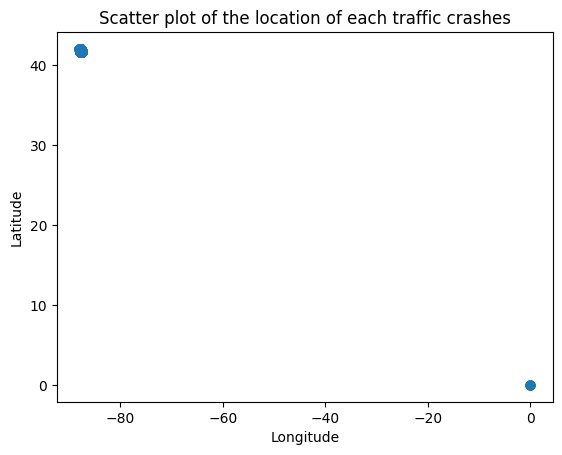

In [ ]:
plt.scatter(df.LONGITUDE, df.LATITUDE)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter plot of the location of each traffic crashes")
plt.show()

Chicago is a city in the U.S., so the data in the bottom right in the above graph have errors in their location information.

In [ ]:
df.drop(index=df[df.LATITUDE < 10].index, inplace=True)

### Feature Engineering
* Creating the target variable "**Severity**" from "**INJURIES_TOTAL**" and "**INJURIES_FATAL**".  
* "Severity" has three levels:  
    * 3: "INJURIES_TOTAL" $>=3$ or "INJURIES_FATAL" $>= 1$  
    * 2: $1<=$ "INJURIES_TOTAL" $<=2$  
    * 1: "INJURIES_TOTAL" $=0$

In [ ]:
df = create_severity(df)

### Reducing demension
#### Removing features obtained after the crash
* Independent variables should not contain features which can be obtained after the traffic crash. Therefore, the following features are removed: "CRASH_TYPE", "DAMAGE", "MOST_SEVERE_INJURY", "INJURIES_TOTAL", "INJURIES_FATAL", "INJURIES_INCAPACITATING", "INJURIES_NON_INCAPACITATING", "INJURIES_REPORTED_NOT_EVIDENT", "INJURIES_NO_INDICATION".

In [ ]:
removed_features = ["CRASH_TYPE", "DAMAGE", "MOST_SEVERE_INJURY", "INJURIES_TOTAL", "INJURIES_FATAL",
                    "INJURIES_INCAPACITATING", "INJURIES_NON_INCAPACITATING", "INJURIES_REPORTED_NOT_EVIDENT",
                    "INJURIES_NO_INDICATION"]
df.drop(columns=removed_features, inplace=True)

#### Removing useless features for taking countermeasures
* "CRASH_DATE_year" cannot be utilized for policies to reduce traffic accidents. Therefore, "CRASH_DATE_year" is removed.

In [ ]:
df.drop(columns=["CRASH_DATE_year"], inplace=True)

#### Removing some location data
* This dataset contains various location features. In the course of building models, we will only use "LATITUDE", "LONGITUDE" as the locational data. Therefore, the following features are removed: "STREET_NO", "STREET_NAME", "BEAT_OF_OCCURRENCE", "LOCATION".

In [ ]:
removed_features = ["STREET_NO", "STREET_NAME", "BEAT_OF_OCCURRENCE", "LOCATION"]
df.drop(columns=removed_features, inplace=True)

### Removing observations with "UNKNOWN"
* Some categorical features have a value "UNKNOWN"
* Our final goal is to find significant features influencing the traffic crash severity. Therefore, "UNKONWN" is not preferable.

In [ ]:
unknown_contained_features=[]
for feature in df.dtypes[df.dtypes==object].index:
    if "UNKNOWN" in df[feature].unique():
        unknown_contained_features.append(feature)

unknown_contained_features

['TRAFFIC_CONTROL_DEVICE',
 'DEVICE_CONDITION',
 'WEATHER_CONDITION',
 'LIGHTING_CONDITION',
 'TRAFFICWAY_TYPE',
 'ROADWAY_SURFACE_COND',
 'ROAD_DEFECT']

In [ ]:
removed_index = set()
for feature in unknown_contained_features:
    removed_index = removed_index | set(df[df[feature]=="UNKNOWN"].index)

print(f"The number of removed observations: {len(removed_index)}.")
df.drop(index=removed_index, inplace=True)

The number of removed observations: 174846.


### Convert data type
* "CRASH_DAY_OF_WEEK" should be categorical. Therefore, its data type is converted to 'Object' type.

In [ ]:
df = df.astype({"CRASH_DAY_OF_WEEK": object, "CRASH_DATE_month": object, "CRASH_DATE_day": object, "CRASH_DATE_hour": object, "CRASH_DATE_minute": object})

## EDA

### Distribution of Severity
* Severity is highly imbalanced

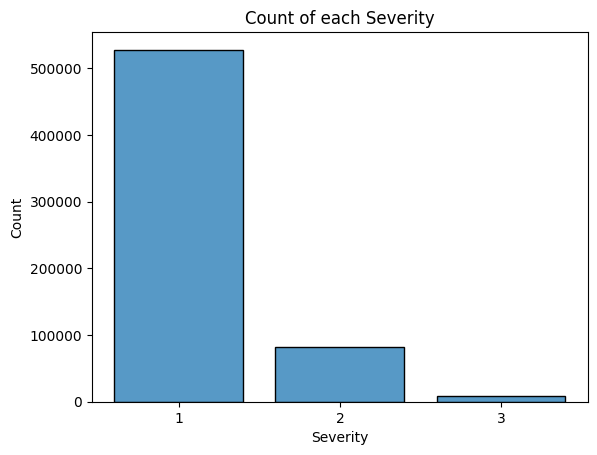

In [ ]:
sns.histplot(df.Severity, discrete=True, shrink=0.8)
plt.xticks([1,2,3])
plt.title("Count of each Severity")
plt.show()

### Count of traffic crashes
#### All observations
* The counts of crashes increase from May to October.
* The counts of crashes on Friday (6) are larger than any other day.
* The counts of crashes have two peaks: at 8 and at 15-17.

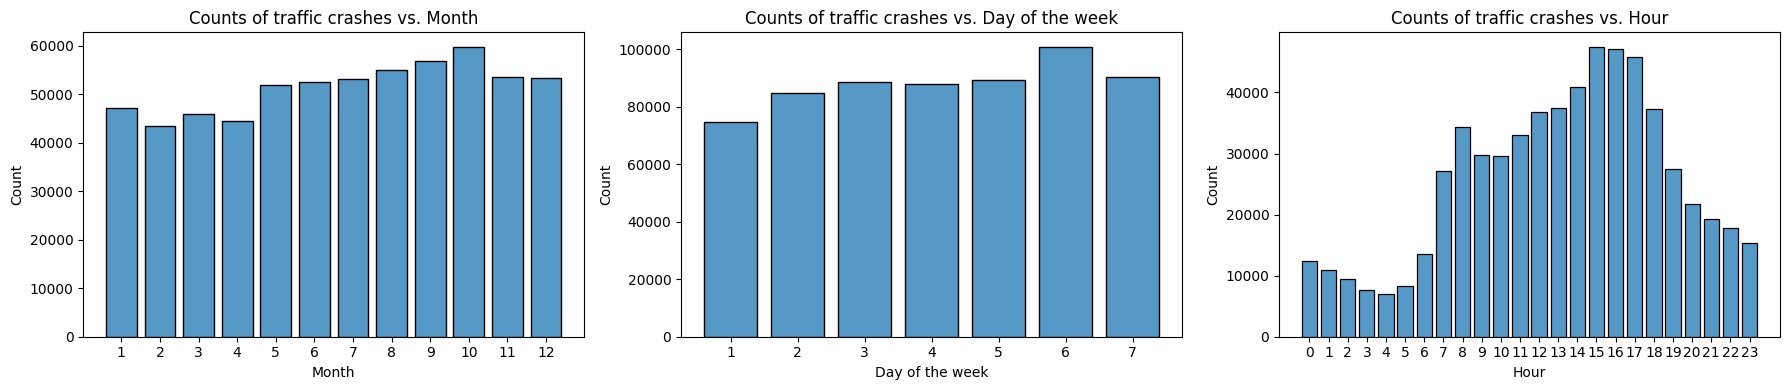

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18, 4))
sns.histplot(data=df, x="CRASH_DATE_month", discrete=True, shrink=0.8, ax=axes[0])
axes[0].set_xticks(range(1, 13))
axes[0].set_xlabel("Month")
axes[0].set_title("Counts of traffic crashes vs. Month")
sns.histplot(data=df, x="CRASH_DAY_OF_WEEK", discrete=True, shrink=0.8, ax=axes[1])
axes[1].set_xticks(range(1, 8))
axes[1].set_xlabel("Day of the week")
axes[1].set_title("Counts of traffic crashes vs. Day of the week")
sns.histplot(data=df, x="CRASH_DATE_hour", discrete=True, shrink=0.8, ax=axes[2])
axes[2].set_xticks(range(0, 24))
axes[2].set_xlabel("Hour")
axes[2].set_title("Counts of traffic crashes vs. Hour")
plt.tight_layout()
plt.show()

#### By Severity
* Severity 3 crashes more occured on Sunday (1) and Saturaday (7)
* Severity 1 and 2 crashes more occured on Friday (6)
* The counts of crashes have two peaks: at 8 and at 15-17.

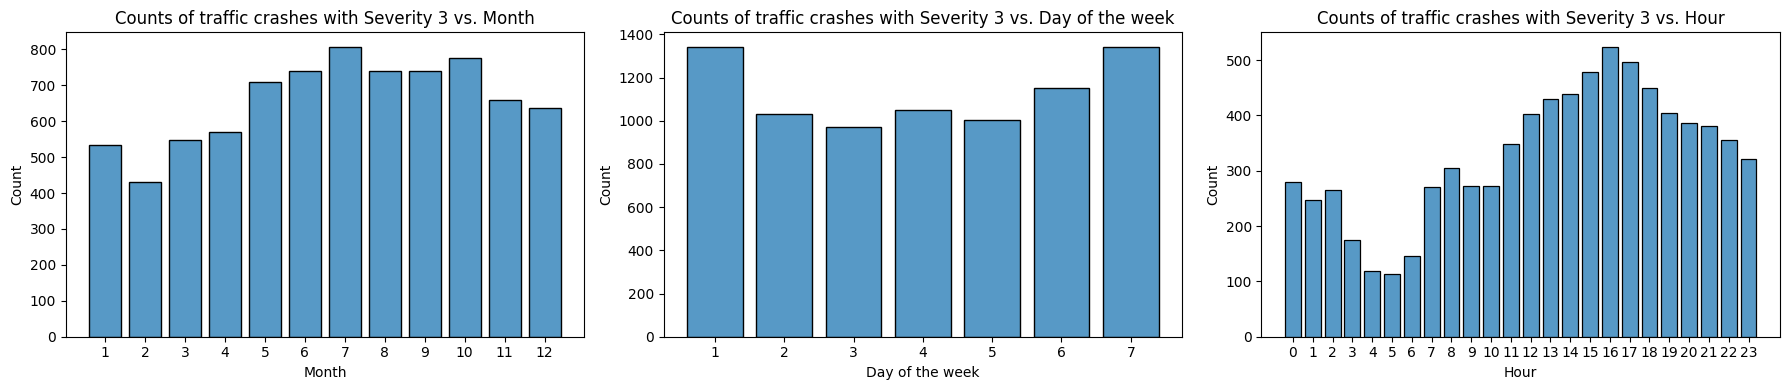

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18, 4))
sns.histplot(df[df.Severity == 3].CRASH_DATE_month, discrete=True, shrink=0.8, ax=axes[0])
axes[0].set_xticks(range(1, 13))
axes[0].set_xlabel("Month")
axes[0].set_title("Counts of traffic crashes with Severity 3 vs. Month")
sns.histplot(df[df.Severity == 3].CRASH_DAY_OF_WEEK, discrete=True, shrink=0.8, ax=axes[1])
axes[1].set_xticks(range(1, 8))
axes[1].set_xlabel("Day of the week")
axes[1].set_title("Counts of traffic crashes with Severity 3 vs. Day of the week")
sns.histplot(df[df.Severity == 3].CRASH_DATE_hour, discrete=True, shrink=0.8, ax=axes[2])
axes[2].set_xticks(range(0, 24))
axes[2].set_xlabel("Hour")
axes[2].set_title("Counts of traffic crashes with Severity 3 vs. Hour")
plt.tight_layout()
plt.show()

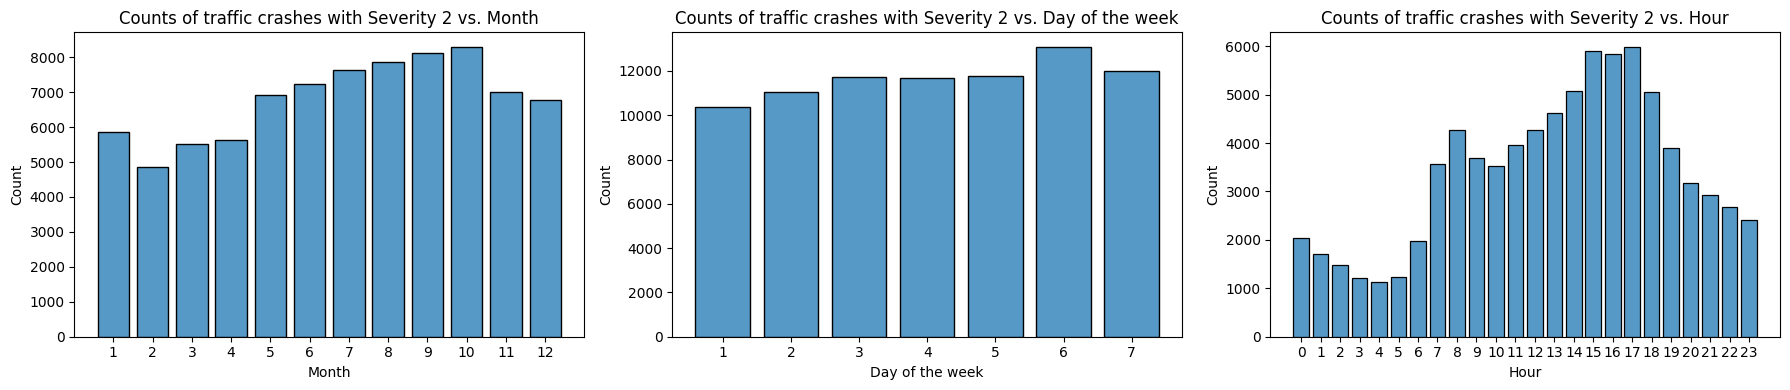

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18, 4))
sns.histplot(df[df.Severity == 2].CRASH_DATE_month, discrete=True, shrink=0.8, ax=axes[0])
axes[0].set_xticks(range(1, 13))
axes[0].set_xlabel("Month")
axes[0].set_title("Counts of traffic crashes with Severity 2 vs. Month")
sns.histplot(df[df.Severity == 2].CRASH_DAY_OF_WEEK, discrete=True, shrink=0.8, ax=axes[1])
axes[1].set_xticks(range(1, 8))
axes[1].set_xlabel("Day of the week")
axes[1].set_title("Counts of traffic crashes with Severity 2 vs. Day of the week")
sns.histplot(df[df.Severity == 2].CRASH_DATE_hour, discrete=True, shrink=0.8, ax=axes[2])
axes[2].set_xticks(range(0, 24))
axes[2].set_xlabel("Hour")
axes[2].set_title("Counts of traffic crashes with Severity 2 vs. Hour")
plt.tight_layout()
plt.show()

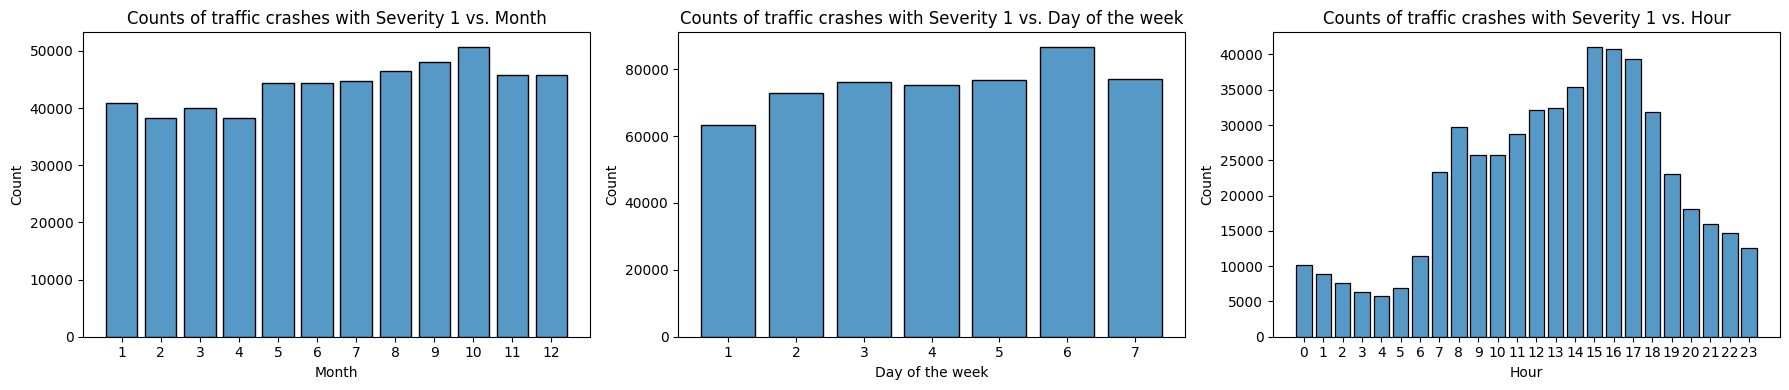

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(18, 4))
sns.histplot(df[df.Severity == 1].CRASH_DATE_month, discrete=True, shrink=0.8, ax=axes[0])
axes[0].set_xticks(range(1, 13))
axes[0].set_xlabel("Month")
axes[0].set_title("Counts of traffic crashes with Severity 1 vs. Month")
sns.histplot(df[df.Severity == 1].CRASH_DAY_OF_WEEK, discrete=True, shrink=0.8, ax=axes[1])
axes[1].set_xticks(range(1, 8))
axes[1].set_xlabel("Day of the week")
axes[1].set_title("Counts of traffic crashes with Severity 1 vs. Day of the week")
sns.histplot(df[df.Severity == 1].CRASH_DATE_hour, discrete=True, shrink=0.8, ax=axes[2])
axes[2].set_xticks(range(0, 24))
axes[2].set_xlabel("Hour")
axes[2].set_title("Counts of traffic crashes with Severity 1 vs. Hour")
plt.tight_layout()
plt.show()

### Traffic control device and Severity
* Majority of the severity 1 crashes happened in "NO CONTROLS"
* The percentage of "TRAFFIC SIGNAL" increase as the severity level increases.

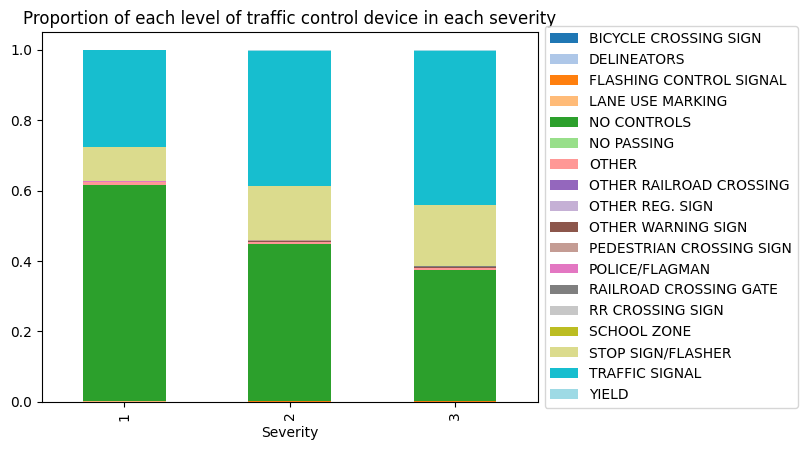

In [ ]:
ratio_tcd = pd.crosstab(df['Severity'], df['TRAFFIC_CONTROL_DEVICE'], normalize='index')
ratio_tcd.plot.bar(stacked=True, cmap='tab20')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of traffic control device in each severity")
plt.show()

### Device condition and Severity

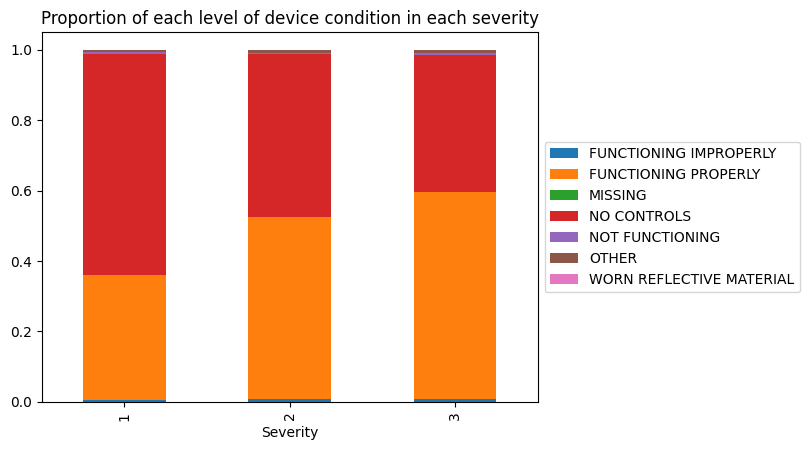

In [ ]:
ratio_dc = pd.crosstab(df['Severity'], df['DEVICE_CONDITION'], normalize='index')
ratio_dc.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of device condition in each severity")
plt.show()

### Weather condition and Severity
* No significant diferences among each severity level

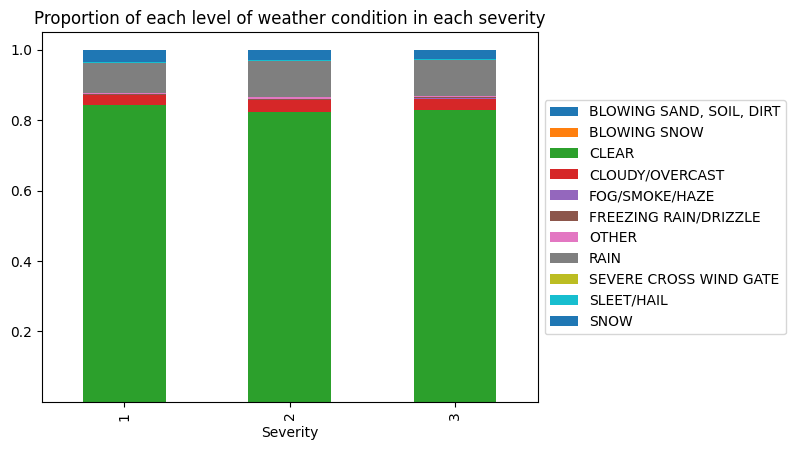

In [ ]:
ratio_wc = pd.crosstab(df['Severity'], df['WEATHER_CONDITION'], normalize='index')
ratio_wc.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of weather condition in each severity")
plt.show()

### Lighting condition vs. Severity
* The percentage of "DARKNESS, LIGHTED ROAD" increases as the severity level increases.

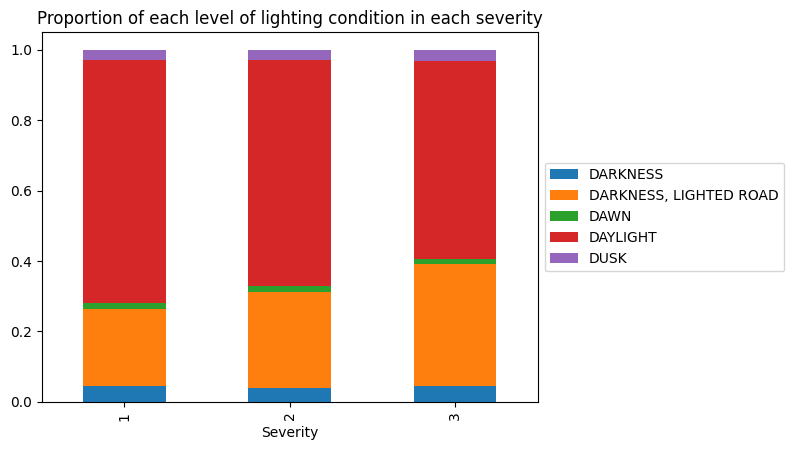

In [ ]:
ratio_lc = pd.crosstab(df['Severity'], df['LIGHTING_CONDITION'], normalize='index')
ratio_lc.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of lighting condition in each severity")
plt.show()

## First crash type and Severity

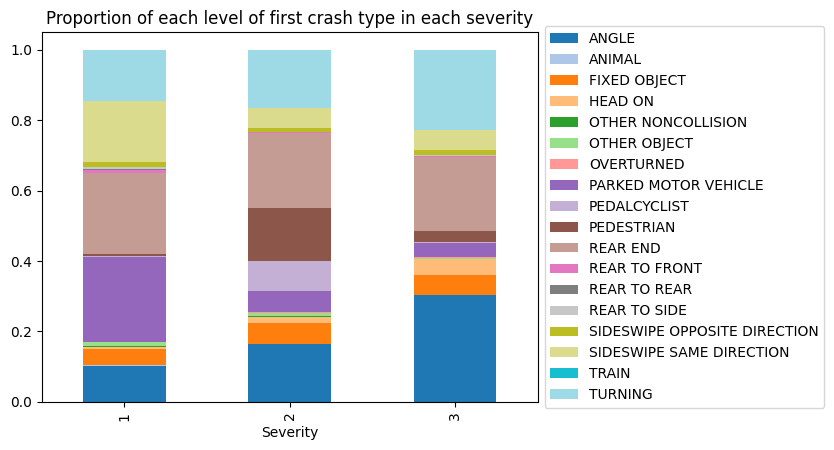

In [ ]:
ratio_fct = pd.crosstab(df['Severity'], df['FIRST_CRASH_TYPE'], normalize='index')
ratio_fct.plot.bar(stacked=True, cmap='tab20')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of first crash type in each severity")
plt.show()

## Trafficway type and Severity

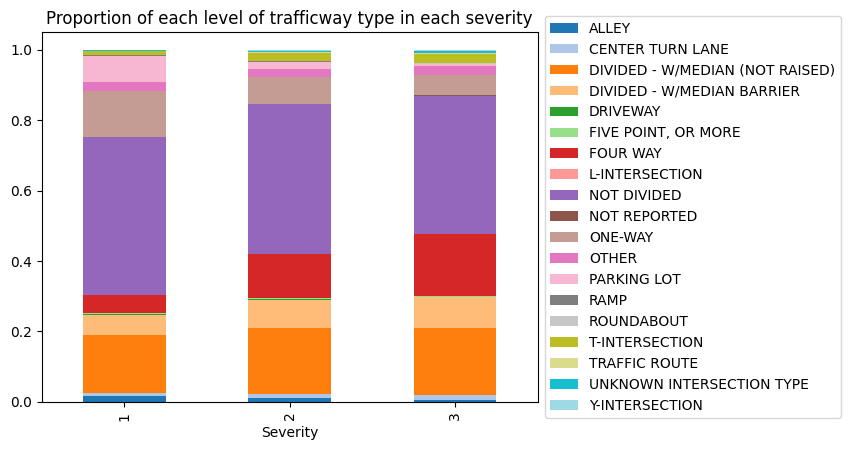

In [ ]:
ratio_tt = pd.crosstab(df['Severity'], df['TRAFFICWAY_TYPE'], normalize='index')
ratio_tt.plot.bar(stacked=True, cmap='tab20')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of trafficway type in each severity")
plt.show()

## Alignment and Severity

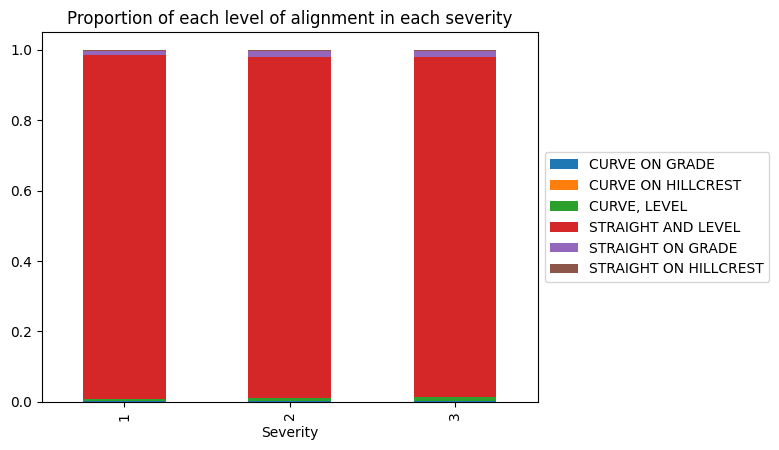

In [ ]:
ratio_a = pd.crosstab(df['Severity'], df['ALIGNMENT'], normalize='index')
ratio_a.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of alignment in each severity")
plt.show()

## Roadway surface condition and Severity

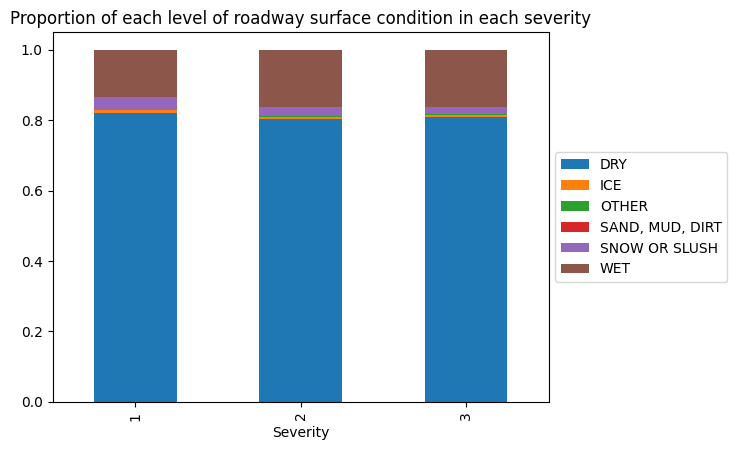

In [ ]:
ratio_rsc = pd.crosstab(df['Severity'], df['ROADWAY_SURFACE_COND'], normalize='index')
ratio_rsc.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of roadway surface condition in each severity")
plt.show()

## Road defect and Severity

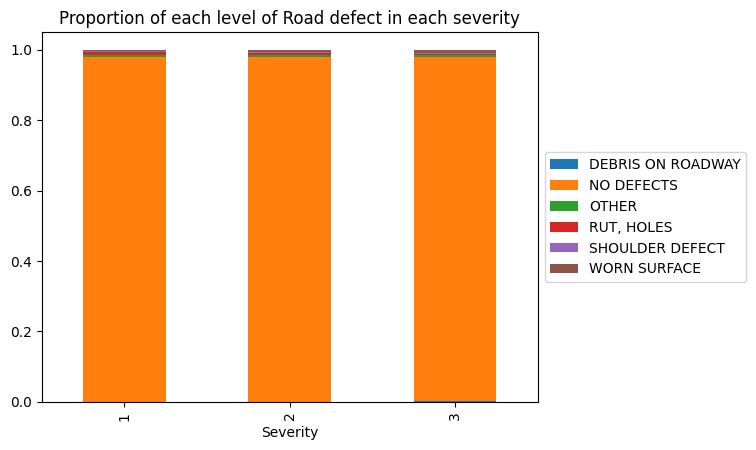

In [ ]:
ratio_rd = pd.crosstab(df['Severity'], df['ROAD_DEFECT'], normalize='index')
ratio_rd.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of Road defect in each severity")
plt.show()

### Prime contributory cause and Severity

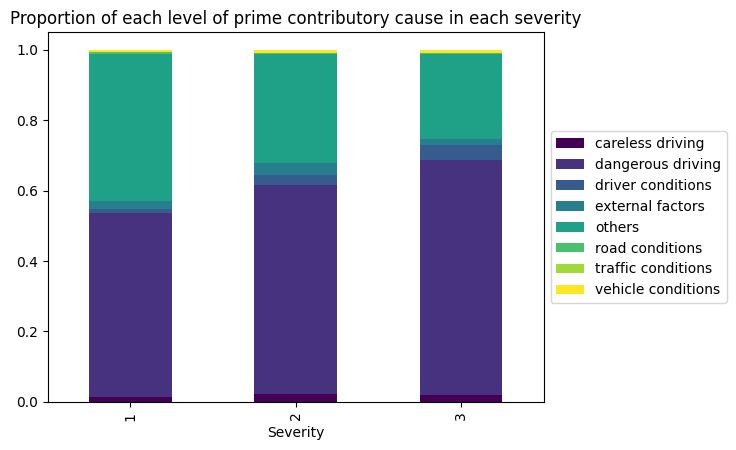

In [ ]:
ratio_pcc = pd.crosstab(df['Severity'], df['PRIM_CONTRIBUTORY_CAUSE'], normalize='index')
ratio_pcc.plot.bar(stacked=True, cmap='viridis')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of prime contributory cause in each severity")
plt.show()

### Second contributory cause and Severity

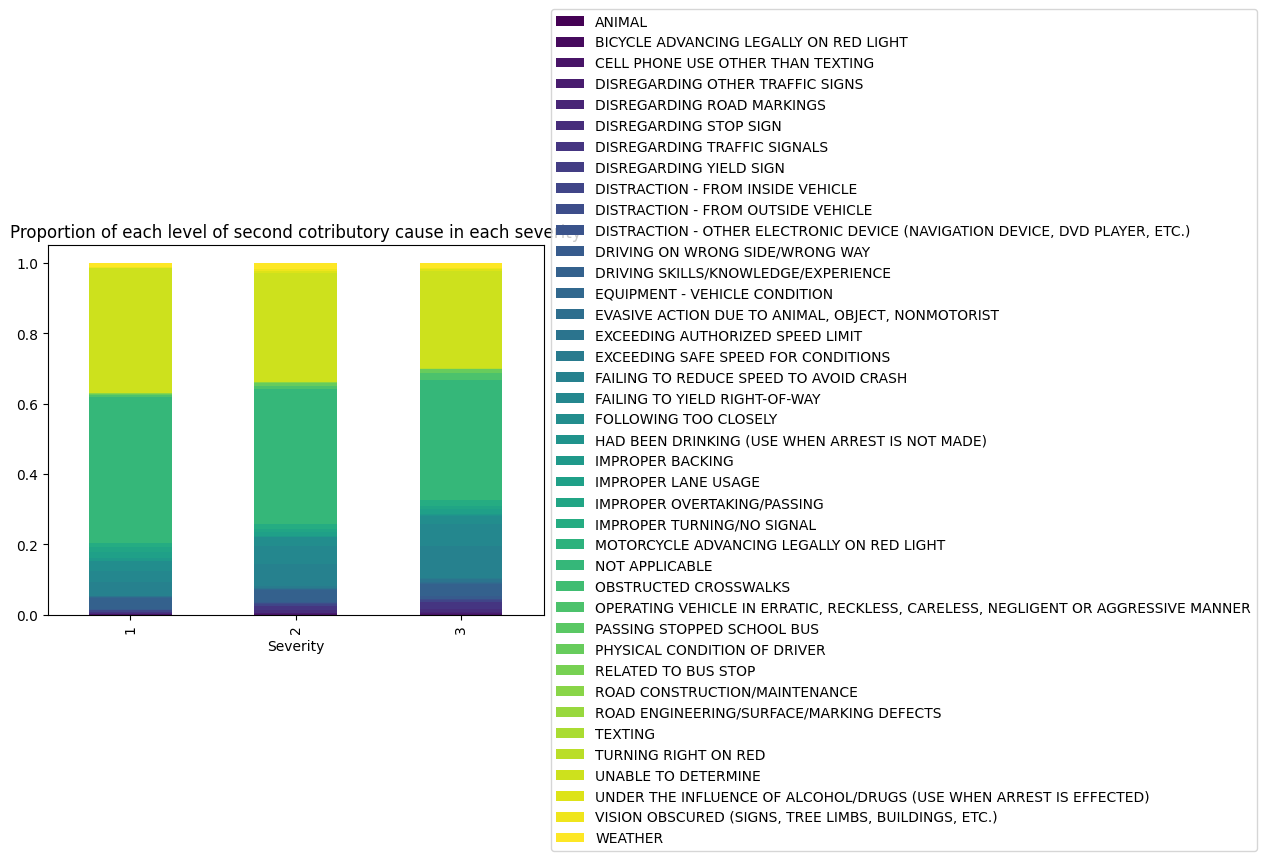

In [ ]:
ratio_scc = pd.crosstab(df['Severity'], df['SEC_CONTRIBUTORY_CAUSE'], normalize='index')
ratio_scc.plot.bar(stacked=True, cmap='viridis')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of second contributory cause in each severity")
plt.show()

### Street direction and Severity

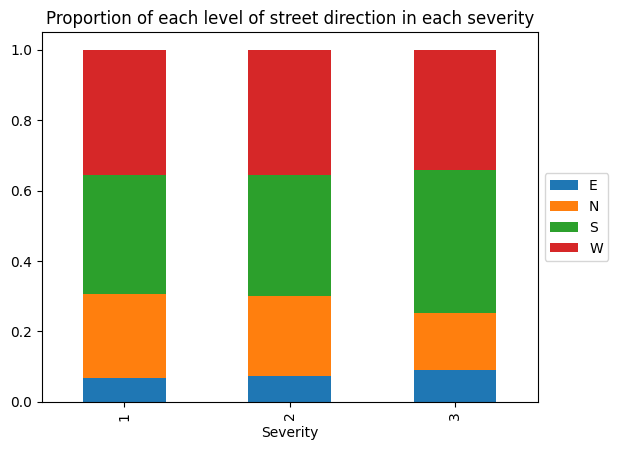

In [ ]:
ratio_sd = pd.crosstab(df['Severity'], df['STREET_DIRECTION'], normalize='index')
ratio_sd.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of street direction in each severity")
plt.show()

### Day of week and Severity

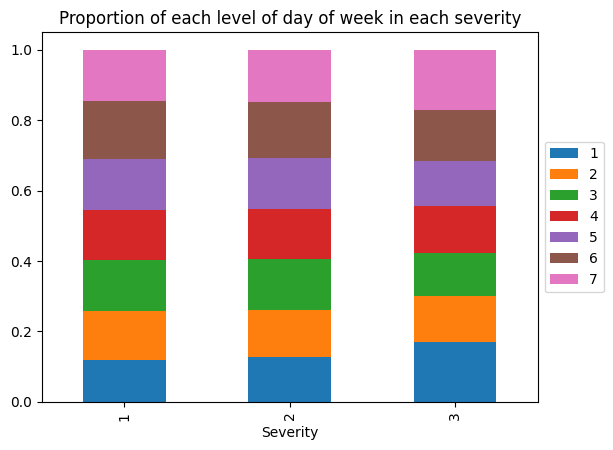

In [ ]:
ratio_dow = pd.crosstab(df['Severity'], df['CRASH_DAY_OF_WEEK'], normalize='index')
ratio_dow.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of day of week in each severity")
plt.show()

### Month and Severity

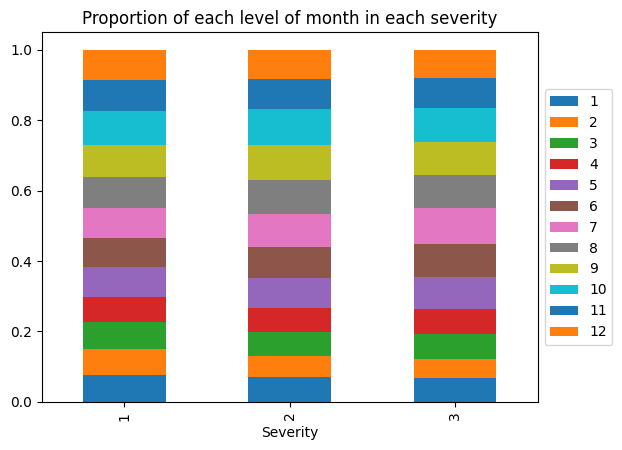

In [ ]:
ratio_mnth = pd.crosstab(df['Severity'], df['CRASH_DATE_month'], normalize='index')
ratio_mnth.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of month in each severity")
plt.show()

### Day and Severity

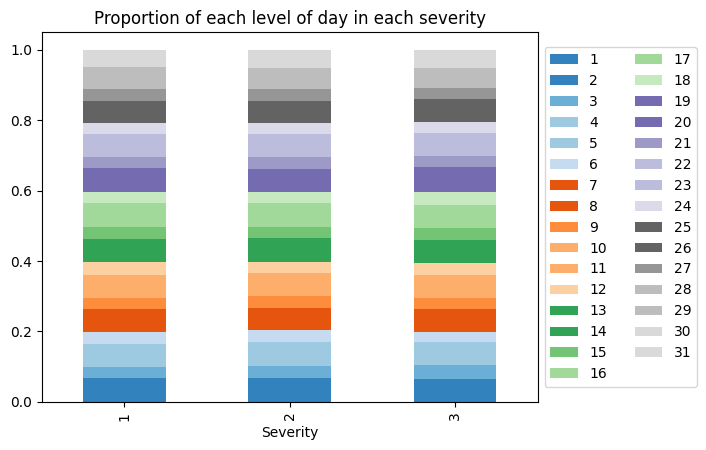

In [ ]:
ratio_day = pd.crosstab(df['Severity'], df['CRASH_DATE_day'], normalize='index')
ratio_day.plot.bar(stacked=True, cmap='tab20c')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
plt.title("Proportion of each level of day in each severity")
plt.show()

### Hour and Severity

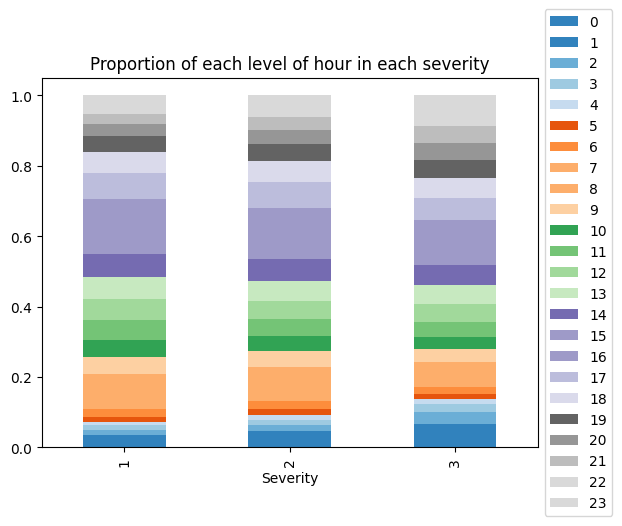

In [ ]:
ratio_hour = pd.crosstab(df['Severity'], df['CRASH_DATE_hour'], normalize='index')
ratio_hour.plot.bar(stacked=True, cmap='tab20c')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of hour in each severity")
plt.show()

### Minute and Severity

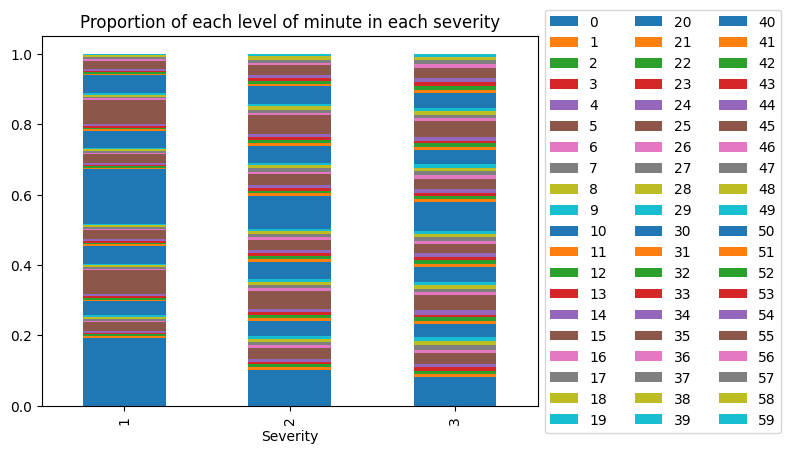

In [ ]:
ratio_minute = pd.crosstab(df['Severity'], df['CRASH_DATE_minute'], normalize='index')
ratio_minute.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
plt.title("Proportion of each level of minute in each severity")
plt.show()

### Geographical distribution of traffic crashes

In [ ]:
# read Chicago map data
chicago = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop"))

# Create Point object
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

Extracting 'chicago_commpop/chicago_commpop.geojson' from '/root/.cache/geodatasets/chicago_commpop.zip' to '/root/.cache/geodatasets/chicago_commpop.zip.unzip'


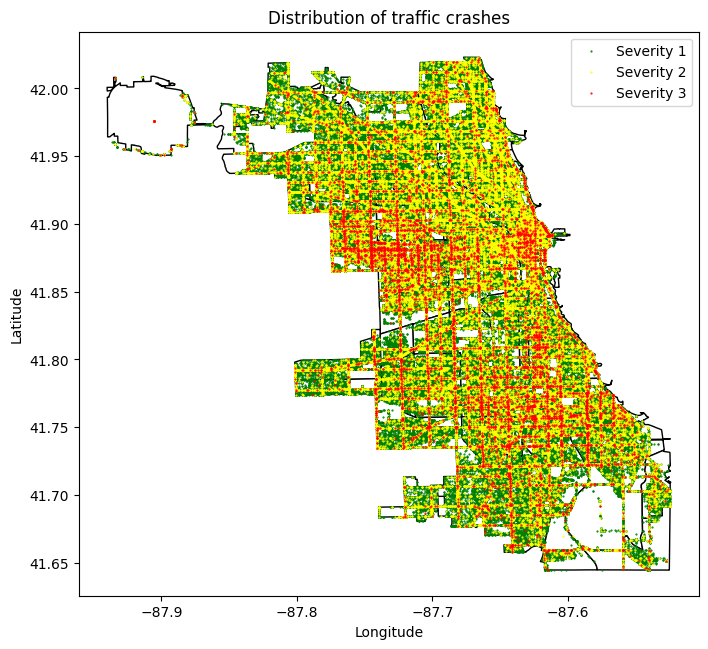

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
chicago.plot(ax=ax, color='white', edgecolor='black')
gdf[gdf.Severity==1].plot(ax=ax, color='green', markersize=0.3, label="Severity 1")
gdf[gdf.Severity==2].plot(ax=ax, color='yellow', markersize=0.3, label="Severity 2")
gdf[gdf.Severity==3].plot(ax=ax, color='red', markersize=0.3, label="Severity 3")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribution of traffic crashes")
plt.show()

### Test of independence
*  Performed the test of independence to see whether "Severity" and each categorical feature were independent.
* Except for "CRASH_DATE_day", all the categorical features were not independent from "Severity" at significance level = 0.05.

In [ ]:
chi_test = independence_test_summary(df, 0.05)

In [ ]:
chi_test

,Feature,Chi-stat,Critical stat,p-value
0,TRAFFIC_CONTROL_DEVICE,10967.366445,48.602367,0.0
1,DEVICE_CONDITION,9732.052822,21.02607,0.0
2,WEATHER_CONDITION,540.118026,31.410433,0.0
3,LIGHTING_CONDITION,1864.354601,15.507313,0.0
4,FIRST_CRASH_TYPE,121098.048133,48.602367,0.0
5,TRAFFICWAY_TYPE,17155.494855,50.99846,0.0
6,ALIGNMENT,273.50059,18.307038,0.0
7,ROADWAY_SURFACE_COND,716.567335,18.307038,0.0
8,ROAD_DEFECT,205.465882,18.307038,0.0
9,PRIM_CONTRIBUTORY_CAUSE,30669.468376,99.616927,0.0


### Posted speed limit and Severity

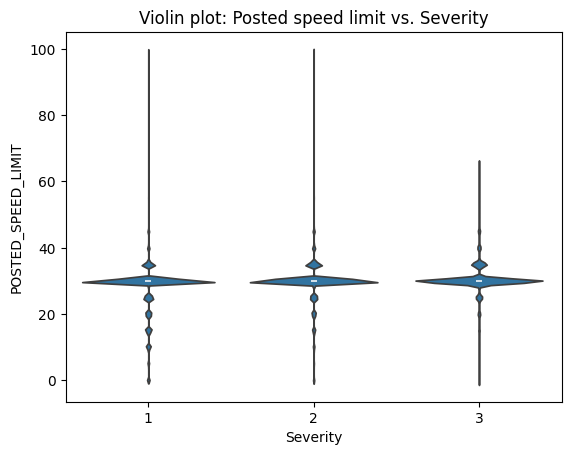

In [ ]:
sns.violinplot(data=df, x="Severity", y="POSTED_SPEED_LIMIT")
plt.title("Violin plot: Posted speed limit vs. Severity")
plt.show()

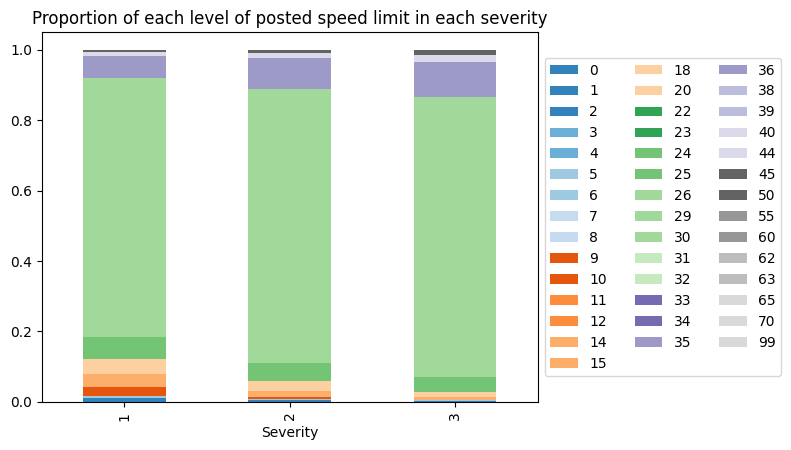

In [ ]:
ratio_speed = pd.crosstab(df['Severity'], df['POSTED_SPEED_LIMIT'], normalize='index')
ratio_speed.plot.bar(stacked=True, cmap="tab20c")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
plt.title("Proportion of each level of posted speed limit in each severity")
plt.show()

### Unit number and Severity

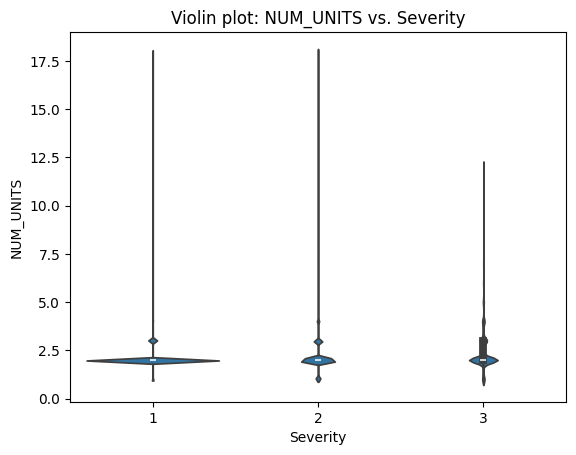

In [ ]:
sns.violinplot(data=df, x="Severity", y="NUM_UNITS")
plt.title("Violin plot: NUM_UNITS vs. Severity")
plt.show()

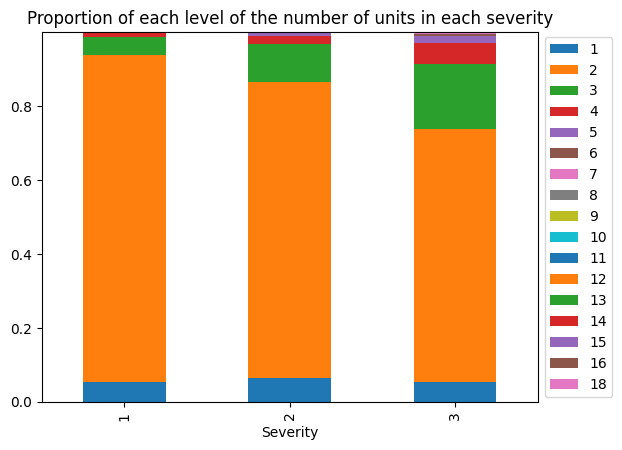

In [ ]:
ratio_num_units = pd.crosstab(df['Severity'], df['NUM_UNITS'], normalize='index')
ratio_num_units.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of the number of units in each severity")
plt.show()

### Latitude and Severity

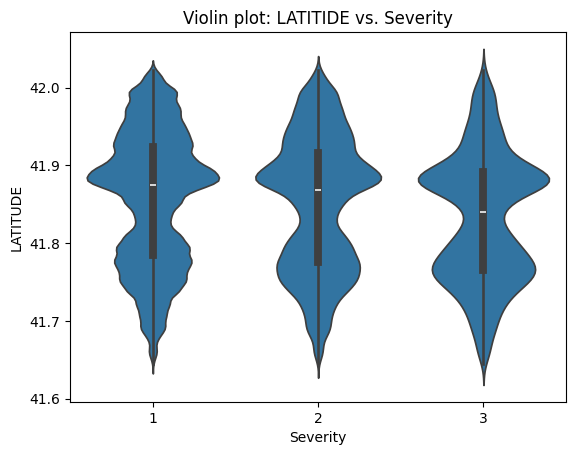

In [ ]:
sns.violinplot(data=df, x="Severity", y="LATITUDE")
plt.title("Violin plot: LATITIDE vs. Severity")
plt.show()

### Longitude and Severity

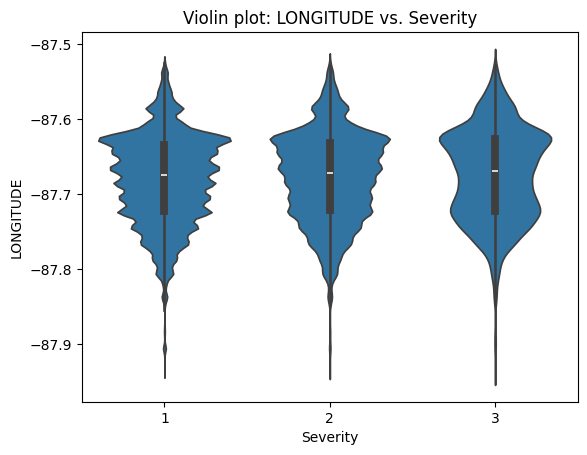

In [ ]:
sns.violinplot(data=df, x="Severity", y="LONGITUDE")
plt.title("Violin plot: LONGITUDE vs. Severity")
plt.show()

### Variance analysis for numerical features
* Examining whether the population of each severity is different for each numerical feature
* ANOVA cannot be applied because the condition of normality is not satisfied
* Kruskal-Wallis test, which is non-parametric test, was performed instead of ANOVA.
* For all numerical features, the population medians were not equal.

In [ ]:
numerical_features = df.describe().columns[:-1]
for feature in numerical_features:
    normal_test(df, feature)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


POSTED_SPEED_LIMIT is NOT normaly distributed
NUM_UNITS is NOT normaly distributed
LATITUDE is NOT normaly distributed
LONGITUDE is NOT normaly distributed


In [ ]:
kruskal_results = kruskal_test(df, numerical_features)

In [ ]:
kruskal_results

,Feature,Kruskal-stat,p-value
0,POSTED_SPEED_LIMIT,4183.468875,0.0
1,NUM_UNITS,4698.597963,0.0
2,LATITUDE,1092.24541,0.0
3,LONGITUDE,164.465917,0.0


## Model Development

### Further preprocessing
#### Categorical feature grouping
* From the above EDA, it turned out that "PRIM_CONTRIBUTORY_CAUSE" and "SEC_CONTRIBUTORY_CAUSE" had as many as 40 levels. Too many levels make the dataframe too high dimension, leading to difficulty in developing models. Therefore, in the following, we will group similar levels into the same category.
* New levels will be created. The new levels include "external factors", "careless driving", "dangerous driving", "vehicle conditions", "driver conditions", "traffic conditions", "Road conditions", "Others".
    * "external factors" includes "ANIMAL", "BICYCLE ADVANCING LEGALLY ON RED LIGHT", "EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST", "MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT", "OBSTRUCTED CROSSWALKS", "VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)", "WEATHER".
    * "careless driving" includes "CELL PHONE USE OTHER THAN TEXTING", "DISTRACTION - FROM INSIDE VEHICLE", "DISTRACTION - FROM OUTSIDE VEHICLE", "DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)", "TEXTING", "TURNING RIGHT ON RED".
    * "dangerous driving" includes "DISREGARDING OTHER TRAFFIC SIGNS", "DISREGARDING ROAD MARKINGS", "DISREGARDING STOP SIGN", "DISREGARDING TRAFFIC SIGNALS", "DISREGARDING YIELD SIGN", "DRIVING ON WRONG SIDE/WRONG WAY", "DRIVING SKILLS/KNOWLEDGE/EXPERIENCE", "EXCEEDING AUTHORIZED SPEED LIMIT", "EXCEEDING SAFE SPEED FOR CONDITIONS", "FAILING TO REDUCE SPEED TO AVOID CRASH", "FAILING TO YIELD RIGHT-OF-WAY", "FOLLOWING TOO CLOSELY", "IMPROPER BACKING", "IMPROPER LANE USAGE", "IMPROPER OVERTAKING/PASSING", "IMPROPER TURNING/NO SIGNAL", "OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER".
    * "vehicle conditions" includes "EQUIPMENT - VEHICLE CONDITION".
    * "driver conditions" includes "HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)", "PHYSICAL CONDITION OF DRIVER", "UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)".
    * "traffic conditions" includes "PASSING STOPPED SCHOOL BUS".
    * "road conditions" includes "RELATED TO BUS STOP", "ROAD CONSTRUCTION/MAINTENANCE", "ROAD ENGINEERING/SURFACE/MARKING DEFECTS".
    * "Others" includes "NOT APPLICABLE" and "UNABLE TO DETERMINE".

In [ ]:
# grouping similar levels
external_factors = ["ANIMAL", "BICYCLE ADVANCING LEGALLY ON RED LIGHT", "EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST", "MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT", "OBSTRUCTED CROSSWALKS", "VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)", "WEATHER"]
careless_driving = ["CELL PHONE USE OTHER THAN TEXTING", "DISTRACTION - FROM INSIDE VEHICLE", "DISTRACTION - FROM OUTSIDE VEHICLE", "DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)", "TEXTING", "TURNING RIGHT ON RED"]
dangerous_driving =["DISREGARDING OTHER TRAFFIC SIGNS", "DISREGARDING ROAD MARKINGS", "DISREGARDING STOP SIGN", "DISREGARDING TRAFFIC SIGNALS", "DISREGARDING YIELD SIGN", "DRIVING ON WRONG SIDE/WRONG WAY", "DRIVING SKILLS/KNOWLEDGE/EXPERIENCE", "EXCEEDING AUTHORIZED SPEED LIMIT", "EXCEEDING SAFE SPEED FOR CONDITIONS", "FAILING TO REDUCE SPEED TO AVOID CRASH", "FAILING TO YIELD RIGHT-OF-WAY", "FOLLOWING TOO CLOSELY", "IMPROPER BACKING", "IMPROPER LANE USAGE", "IMPROPER OVERTAKING/PASSING", "IMPROPER TURNING/NO SIGNAL", "OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER"]
vehicle_conditions = ["EQUIPMENT - VEHICLE CONDITION"]
driver_conditions = ["HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)", "PHYSICAL CONDITION OF DRIVER", "UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)"]
traffic_conditions = ["PASSING STOPPED SCHOOL BUS"]
road_conditions = ["RELATED TO BUS STOP", "ROAD CONSTRUCTION/MAINTENANCE", "ROAD ENGINEERING/SURFACE/MARKING DEFECTS"]
others = ["NOT APPLICABLE", "UNABLE TO DETERMINE"]

mapping = {
    **{cause: "external factors" for cause in external_factors},
    **{cause: "careless driving" for cause in careless_driving},
    **{cause: "dangerous driving" for cause in dangerous_driving},
    **{cause: "vehicle conditions" for cause in vehicle_conditions},
    **{cause: "driver conditions" for cause in driver_conditions},
    **{cause: "traffic conditions" for cause in traffic_conditions},
    **{cause: "road conditions" for cause in road_conditions},
    **{cause: "others" for cause in others}
}

for feature in ["PRIM_CONTRIBUTORY_CAUSE", "SEC_CONTRIBUTORY_CAUSE"]:
    df[feature] = df[feature].replace(mapping)

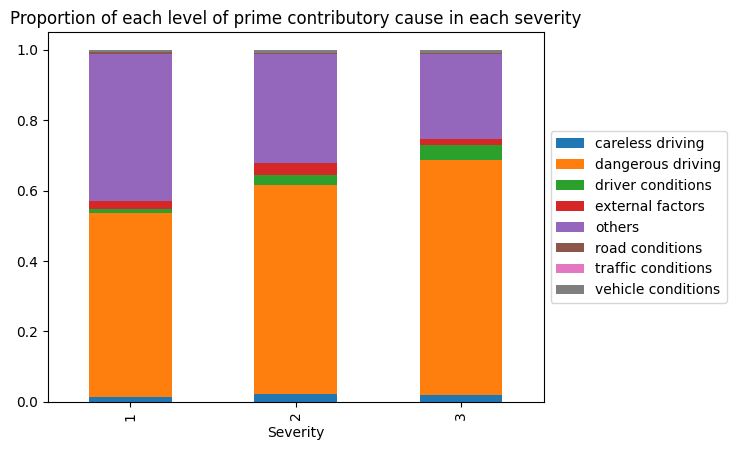

In [ ]:
ratio_pcc = pd.crosstab(df['Severity'], df['PRIM_CONTRIBUTORY_CAUSE'], normalize='index')
ratio_pcc.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of prime contributory cause in each severity")
plt.show()

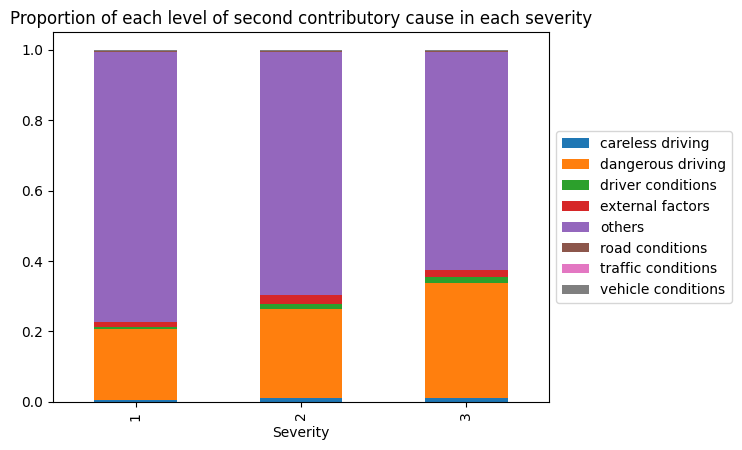

In [ ]:
ratio_scc = pd.crosstab(df['Severity'], df['SEC_CONTRIBUTORY_CAUSE'], normalize='index')
ratio_scc.plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Proportion of each level of second contributory cause in each severity")
plt.show()

#### Removing insignificant features
* From the statistical test, we cannot dismiss the hypothesis that the target variable and "CRASH_DATE_day" are independent. Therefore, we will remove this feature to reduce demension.
* "CRASH_DATE_minute" is showed not to be independent from the target variable. However, the proportion of rounded values is large, indicating a bias. Indeed, it is unlikely that traffic accidents are biased towards specific minutes, and it is not preferable to incorporate this into the model as it is. Therefore, we will also remove "CRASH_DATE_minute".

In [ ]:
df.drop(columns=["CRASH_DATE_day", "CRASH_DATE_minute"], inplace=True)

#### Split the data into training, validation, and test sets
* Split the data: 60% for training, 20% for validation, and 20% for test.

In [ ]:
from sklearn.model_selection import train_test_split

# Divide the data into training (60%) and test (40%)
df_train, df_test = train_test_split(df,
                                     train_size=0.6,
                                     random_state=6501,
                                     stratify=df["Severity"])

# Divide the test data into validation (50%) and test (50%)
df_val, df_test = train_test_split(df_test,
                                   train_size=0.5,
                                   random_state=6501,
                                   stratify=df_test["Severity"])

# Reset the index
df_train, df_val, df_test = df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

#### Split the data into the feature and target

In [ ]:
# Get the target vector
y_train = df_train["Severity"].values
y_val = df_val["Severity"].values
y_test = df_test["Severity"].values

# Get the feature dataframe
df_train_x = df_train.drop(columns=["Severity"])
df_val_x = df_val.drop(columns=["Severity"])
df_test_x = df_test.drop(columns=["Severity"])

#### Standardizing the numerical features

In [ ]:
numerical_features_train = df_train_x[numerical_features].values
numerical_features_val = df_val_x[numerical_features].values
numerical_features_test = df_test_x[numerical_features].values

In [ ]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

# Standardize the data
df_train_x_num = pd.DataFrame(ss.fit_transform(numerical_features_train), columns=numerical_features)
df_val_x_num = pd.DataFrame(ss.transform(numerical_features_val), columns=numerical_features)
df_test_x_num = pd.DataFrame(ss.transform(numerical_features_test), columns=numerical_features)

# Concat the categorical data and the standardized numerical data
df_train_x = pd.concat([df_train_x.drop(columns=numerical_features), df_train_x_num], axis=1)
df_val_x = pd.concat([df_val_x.drop(columns=numerical_features), df_val_x_num], axis=1)
df_test_x = pd.concat([df_test_x.drop(columns=numerical_features), df_test_x_num], axis=1)

with open('standard_scaler.pkl', 'wb') as f:
    pickle.dump(ss, f)

#### SMOTE/Random Under Sampling

##### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTENC

# Get  the position of categorical features
categorical_features = df_train_x.dtypes[df_train_x.dtypes==object].index
cat_pos = []
for i in range(len(df_train_x.columns)):
    if df_train_x.columns[i] in categorical_features:
        cat_pos.append(i)

# The SMOTE
smote_nc = SMOTENC(categorical_features=cat_pos, random_state=6501)

# Augment the training data
X_train_smote, y_train_smote = smote_nc.fit_resample(df_train_x.values, y_train)
df_train_smote = pd.DataFrame(X_train_smote, columns=df_train_x.columns)

##### Random Under Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=6501)
X_train_res, y_train_res = rus.fit_resample(df_train_x.values, y_train)
df_train_res = pd.DataFrame(X_train_res, columns=df_train_x.columns)

#### Write the preprocessed data

In [ ]:
df_train = df_train_smote.copy(deep=True)
df_train["Severity"] = y_train_smote

step = 250000

for i in range(0, df_train.shape[0], step):
    DATA_SPLIT = df_train.iloc[i:i+step,:]
    DATA_SPLIT.to_csv('Data/train_smote_' + str(i//step+1) +'.csv' ,index = False)


df_train = df_train_res.copy(deep=True)
df_train["Severity"] = y_train_res
df_train.to_csv("Data/train_us.csv", index = False)

df_val = df_val_x.copy(deep=True)
df_val["Severity"] = y_val
df_val.to_csv("Data/val.csv", index = False)

df_test = df_test_x.copy(deep=True)
df_test["Severity"] = y_test
df_test.to_csv("Data/test.csv", index = False)